In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Enable TensorFlow 2.x behavior explicitly
tf.enable_v2_behavior()

# --- Xilinx Toolchain Setup ---
VITIS_PATH = '/mnt/f/Xilinx/Vitis/2024.2'
VIVADO_PATH = '/mnt/f/Xilinx/Vivado/2024.2/bin'
VITIS_HLS_PATH = '/mnt/f/Xilinx/Vitis_HLS/2024.2/bin'

# Set environment variables for Vitis
os.environ['XILINX_VITIS'] = VITIS_PATH
os.environ['PATH'] = f"{VIVADO_PATH}:{VITIS_HLS_PATH}:" + os.environ['PATH']

# --- Optional sanity checks ---
for path in [VITIS_PATH, VIVADO_PATH, VITIS_HLS_PATH]:
    if not os.path.exists(path):
        print(f"⚠️  Warning: {path} does not exist!")

print("✅ Environment configured for Xilinx toolchain.")


2025-07-01 20:41:57.764820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 20:41:57.826552: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 20:41:57.829248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-01 20:41:57.829257: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

✅ Environment configured for Xilinx toolchain.


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Flatten the images for MLP: 28x28 → 784
x_train = x_train.reshape((-1, 784))
x_test  = x_test.reshape((-1, 784))

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Split off a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create tf.data.Dataset objects
batch_size = 1024

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
val_data   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_data  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Metadata
n_epochs = 10
train_size = len(x_train)
input_shape = (784,)  # flat input for MLP
n_classes = 10


2025-07-01 20:41:59.175056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-07-01 20:41:59.175077: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-07-01 20:41:59.175092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SagittariusA): /proc/driver/nvidia/version does not exist
2025-07-01 20:41:59.175296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Input(shape=input_shape),       # (784,)
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=n_epochs,
    verbose=1
)

Epoch 1/10
53/53 [==============================] - 0s 3ms/step - loss: 1.1408 - accuracy: 0.6812 - val_loss: 0.4629 - val_accuracy: 0.8760
Epoch 2/10
53/53 [==============================] - 0s 1ms/step - loss: 0.3703 - accuracy: 0.8979 - val_loss: 0.3019 - val_accuracy: 0.9172
Epoch 3/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2776 - accuracy: 0.9217 - val_loss: 0.2541 - val_accuracy: 0.9275
Epoch 4/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.9340 - val_loss: 0.2169 - val_accuracy: 0.9383
Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9435 - val_loss: 0.1929 - val_accuracy: 0.9447
Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9502 - val_loss: 0.1799 - val_accuracy: 0.9480
Epoch 7/10
53/53 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9546 - val_loss: 0.1645 - val_accuracy: 0.9527
Epoch 8/10
53/53 [==

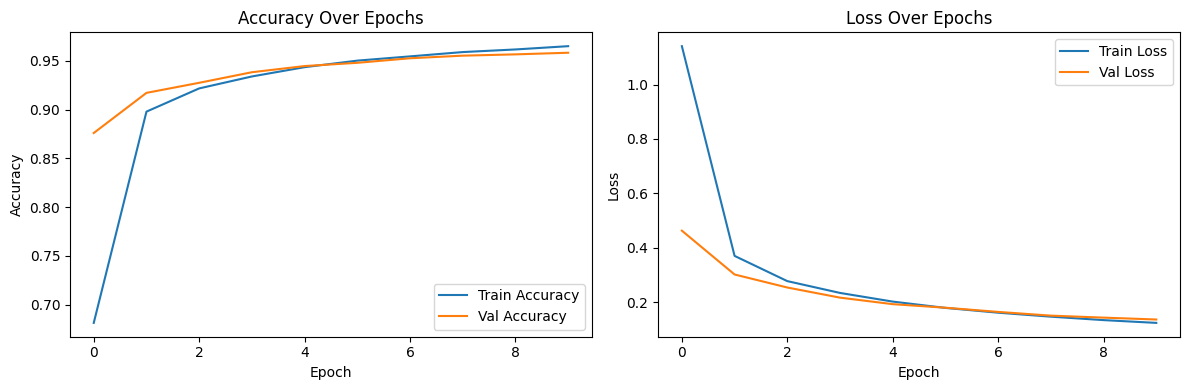

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
max_layer_size = 0
for layer in model.layers:
    if layer.__class__.__name__ in ['Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            if layersize > max_layer_size:
                max_layer_size = layersize
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

print(f"The max_layer_size is {max_layer_size}")

dense: 50176
Layer dense is too large (50176), are you sure you want to train?
dense_1: 2048
dense_2: 320
The max_layer_size is 50176


In [7]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size
print('Number of training steps per epoch is {}'.format(NSTEPS))
# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Number of training steps per epoch is 47
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
models_path = 'models'

train = True  # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 30

save_path = os.path.join(models_path, 'pruned_cnn_model.h5')

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    model_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))
    model_pruned.save(save_path)


else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
53/53 [==============================] - 1s 3ms/step - loss: 0.1329 - accuracy: 0.9615 - val_loss: 0.1315 - val_accuracy: 0.9627 - lr: 0.0030
Epoch 2/30
53/53 [==============================] - 0s 2ms/step - loss: 0.1063 - accuracy: 0.9689 - val_loss: 0.1175 - val_accuracy: 0.9665 - lr: 0.0030
Epoch 3/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0914 - accuracy: 0.9739 - val_loss: 0.1156 - val_accuracy: 0.9662 - lr: 0.0030
Epoch 4/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0846 - accuracy: 0.9753 - val_loss: 0.1105 - val_accuracy: 0.9688 - lr: 0.0030
Epoch 5/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.9758 - val_loss: 0.1028 - val_accuracy: 0.9715 - lr: 0.0030
Epoch 6/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0745 - accuracy: 0.9784 - val_loss: 0.0997 - val_accuracy: 0.9715 - lr: 0.0030
Epoch 7/30
53/53 [==============================] - 0s 2ms/step - loss: 0.0693 - a

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Activation
from qkeras import QDense, QActivation
from tensorflow.keras.regularizers import l1

# Example MLP configuration
input_shape = (784,)  # for MNIST flattened
neurons_per_dense_layer = [64, 32]  # feel free to change
n_classes = 10

x_in = Input(shape=input_shape, name='input_layer')
x = x_in

# Add quantized Dense + BN + Activation blocks
for i, n in enumerate(neurons_per_dense_layer):
    print(f"Adding QDense block {i} with N={n} neurons")
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6, 0, alpha=1)",
        bias_quantizer="quantized_bits(6, 0, alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name=f'dense_{i}',
        use_bias=True
    )(x)
    x = BatchNormalization(name=f'bn_dense_{i}')(x)
    x = QActivation('quantized_relu(6)', name=f'dense_act_{i}')(x)

# Output layer (not quantized in this case — can be made quantized too)
x = QDense(n_classes, name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

# Build model
qmodel = Model(inputs=x_in, outputs=x_out, name='qkeras_mlp')
qmodel.summary()


Adding QDense block 0 with N=64 neurons
Adding QDense block 1 with N=32 neurons
Model: "qkeras_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 dense_0 (QDense)            (None, 64)                50240     
                                                                 
 bn_dense_0 (BatchNormalizat  (None, 64)               256       
 ion)                                                            
                                                                 
 dense_act_0 (QActivation)   (None, 64)                0         
                                                                 
 dense_1 (QDense)            (None, 32)                2080      
                                                                 
 bn_dense_1 (BatchNormalizat  (None, 32)  

In [10]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

dense_0              u=64 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=32 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)
output_dense         u=10 



In [11]:
qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)

In [12]:
train = True

q_save_path = os.path.join(models_path, 'quantized_pruned_cnn_model.h5')

n_epochs = 30
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save(q_save_path)

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
53/53 [==============================] - 1s 5ms/step - loss: 0.9678 - accuracy: 0.8272 - val_loss: 0.7458 - val_accuracy: 0.9043 - lr: 0.0030
Epoch 2/30
53/53 [==============================] - 0s 3ms/step - loss: 0.4198 - accuracy: 0.9357 - val_loss: 0.4142 - val_accuracy: 0.9382 - lr: 0.0030
Epoch 3/30
53/53 [==============================] - 0s 3ms/step - loss: 0.3012 - accuracy: 0.9536 - val_loss: 0.3373 - val_accuracy: 0.9410 - lr: 0.0030
Epoch 4/30
53/53 [==============================] - 0s 3ms/step - loss: 0.2465 - accuracy: 0.9632 - val_loss: 0.2847 - val_accuracy: 0.9520 - lr: 0.0030
Epoch 5/30
53/53 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9681 - val_loss: 0.2530 - val_accuracy: 0.9590 - lr: 0.0030
Epoch 6/30
53/53 [==============================] - 0s 3ms/step - loss: 0.1922 - accuracy: 0.9719 - val_loss: 0.2594 - val_accuracy: 0.9532 - lr: 0.0030
Epoch 7/30
53/53 [==============================] - 0s 3ms/step - loss: 0.1758 - a

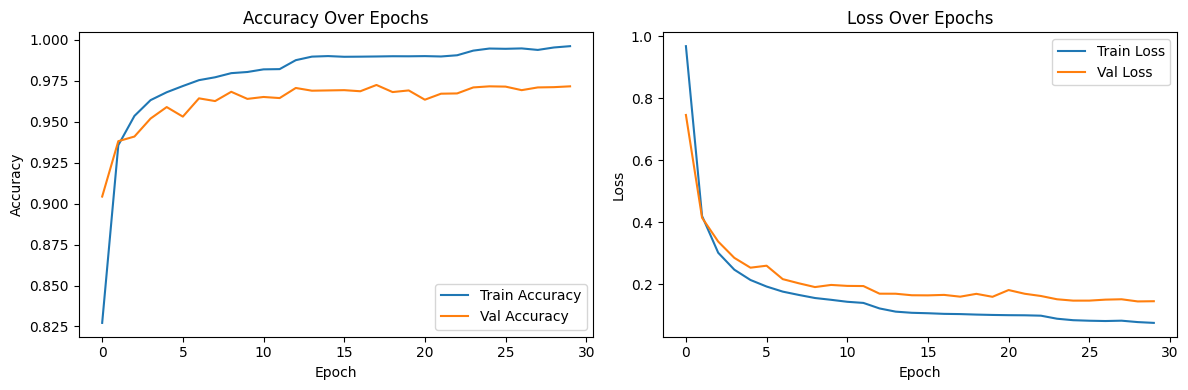

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
predict_baseline = model_pruned.predict(x_test)
test_score_baseline = model_pruned.evaluate(x_test, y_test)

predict_qkeras = qmodel_pruned.predict(x_test)
test_score_qkeras = qmodel_pruned.evaluate(x_test, y_test)

print(f'Keras accuracy = {test_score_baseline[1]*100:.2f}% , QKeras 6-bit accuracy = {test_score_qkeras[1]*100:.2f}%')

313/313 [==============================] - 0s 563us/step - loss: 0.1415 - accuracy: 0.9725
Keras accuracy = 97.03% , QKeras 6-bit accuracy = 97.25%


Layer prune_low_magnitude_dense: % of zeros = 0.5
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer prune_low_magnitude_dense_2: % of zeros = 0.5
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


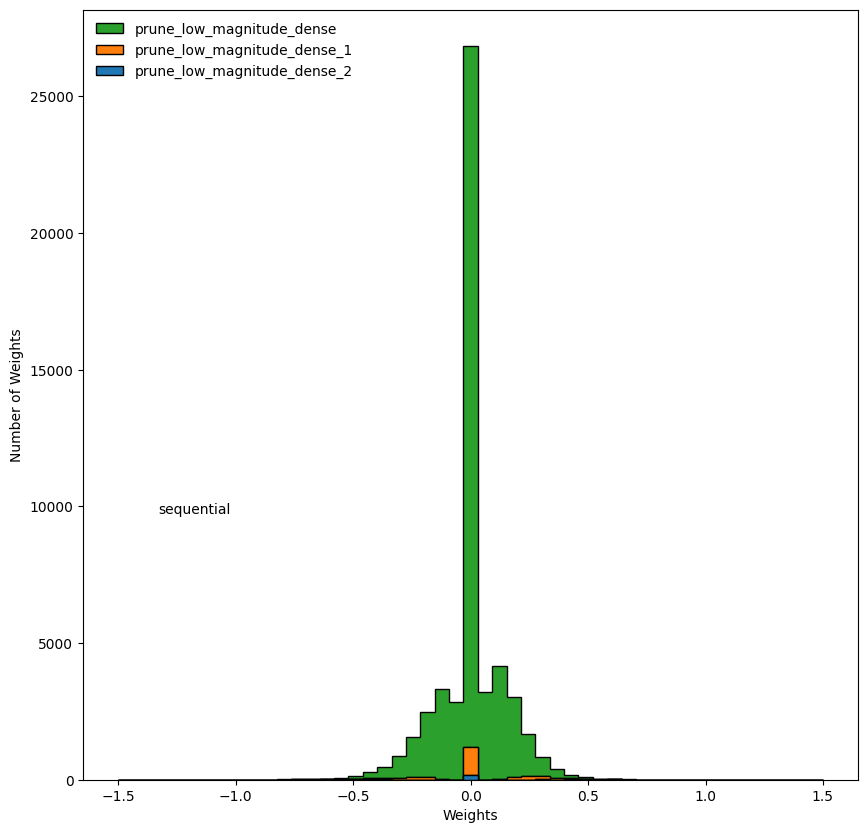

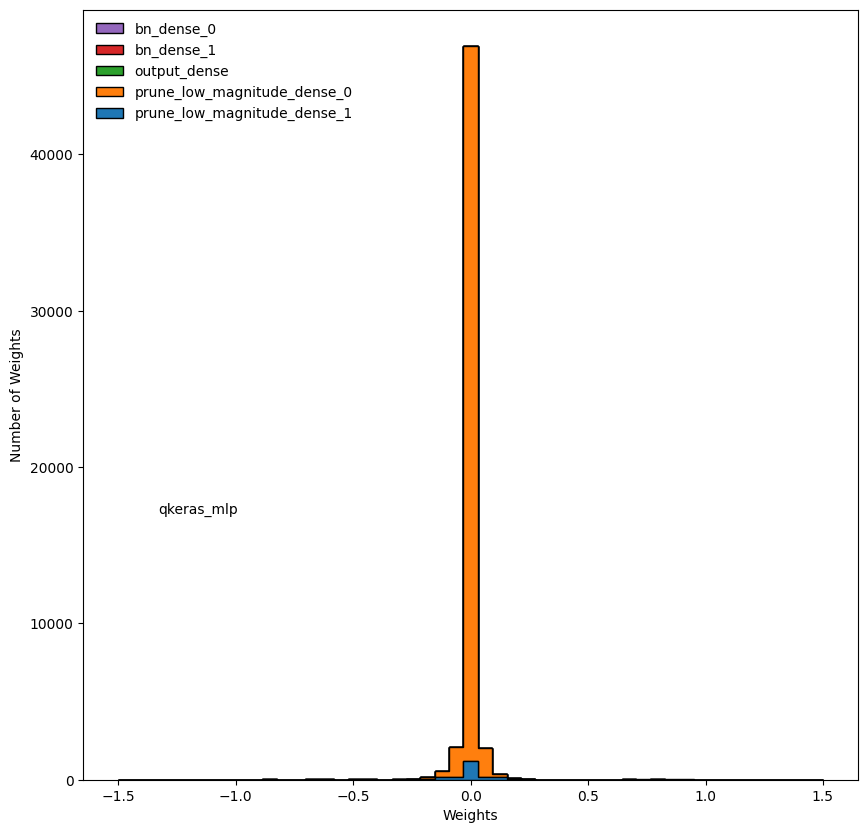

In [15]:
def doWeights(model):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, model._name, wrap=True, horizontalalignment='left', verticalalignment='center')


doWeights(model_pruned)
doWeights(qmodel_pruned)


In [16]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model(save_path, custom_objects=co)
model = strip_pruning(model)

qmodel = tf.keras.models.load_model(q_save_path, custom_objects=co)
qmodel = strip_pruning(qmodel)

In [17]:
project_folder = 'Projects'

In [18]:
import hls4ml

# Auto-generate base config
hls_config = hls4ml.utils.config_from_keras_model(
    model,
    granularity='name',
    backend='Vitis',
    default_precision='ap_fixed<16,6>'
)

# Custom performance overrides
for layer_name, layer_cfg in hls_config['LayerName'].items():
    layer_cfg['Strategy'] = 'Latency'
    layer_cfg['ReuseFactor'] = 32
    if 'FifoDepth' not in layer_cfg:
        layer_cfg['FifoDepth'] = 4


save_proj_path = os.path.join(project_folder, 'Baseline')

# Convert and compile
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=hls_config,
    backend='Vitis',
    output_dir=save_proj_path,
    part='xqzu5ev-sfrc784-1L-i',
    io_type='io_stream',
    clock_period=5,
)
hls_model.compile()


Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: dense, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 64]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 10]
Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: dense, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 64]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 10]
Creating HLS model
Writing HLS project


Done


Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: dense, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 64]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 10]
Creating HLS model
Profiling weights (before optimization)
Profiling weights (final / after optimization)


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

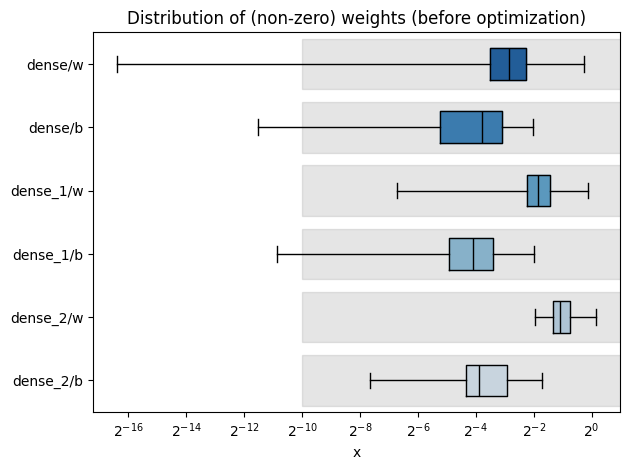

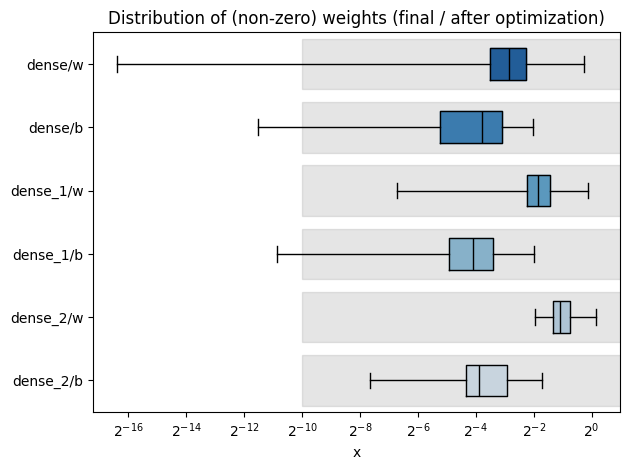

In [19]:
from hls4ml.model.profiling import numerical
numerical(model=model, hls_model=hls_model)

In [20]:
# Generate config from QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(
    qmodel,
    granularity='name',
    backend='Vitis',
)

# Inject optimizations
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['Model']['PruneReuseFactorStrategy'] = 'load_balance'

for lname, lcfg in hls_config_q['LayerName'].items():
    lcfg['Strategy'] = 'Latency'
    lcfg['ReuseFactor'] = 32
    


save_proj_path = os.path.join(project_folder, 'Quantized')

# Convert and compile
hls_model_q = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=hls_config_q,
    output_dir=save_proj_path,
    backend='Vitis',
    io_type='io_stream',
    clock_period=5,
    part = 'xqzu5ev-sfrc784-1L-i',
)

hls_model_q.compile()

Interpreting Model
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: dense_0, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 64]
Layer name: bn_dense_0, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: dense_act_0, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: bn_dense_1, layer type: BatchNormalization, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: dense_act_1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output_dense, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 10]
Layer name: output_softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
Interpreting Model
Topology:
Layer name: input_layer, l

Done


Interpreting Model
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: dense_0, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 64]
Layer name: bn_dense_0, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: dense_act_0, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: bn_dense_1, layer type: BatchNormalization, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: dense_act_1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output_dense, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 10]
Layer name: output_softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
Creating HLS model
Profiling weights (before optimizati

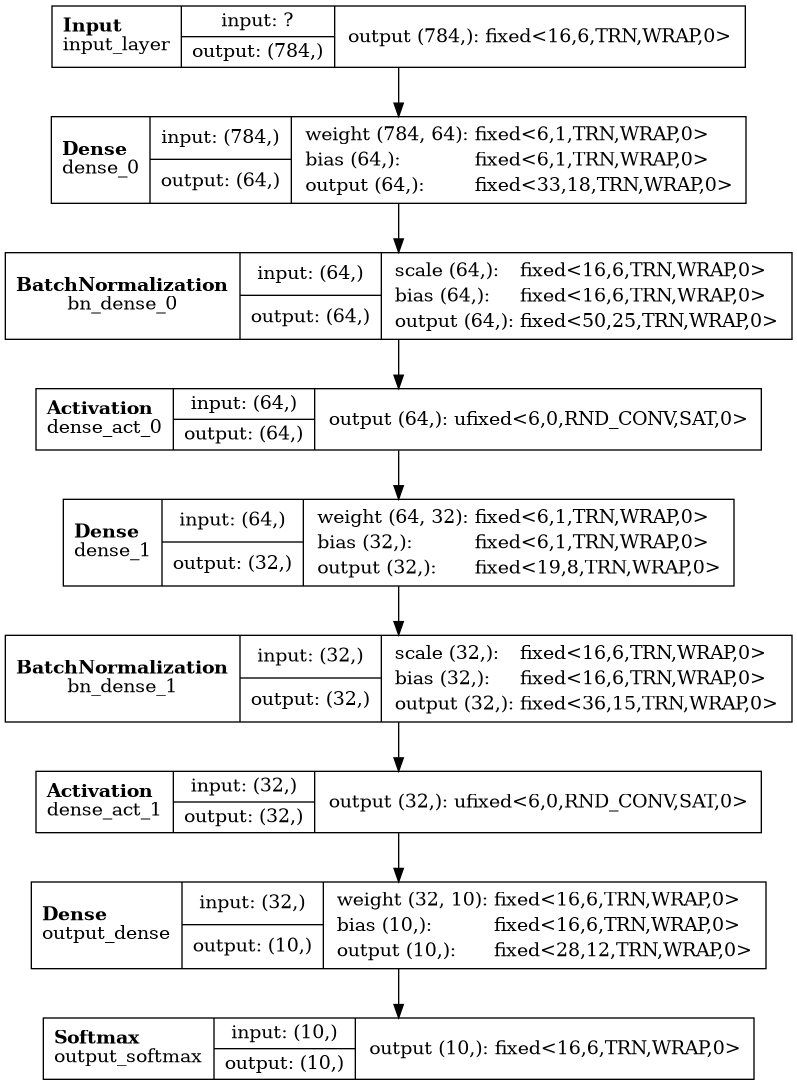

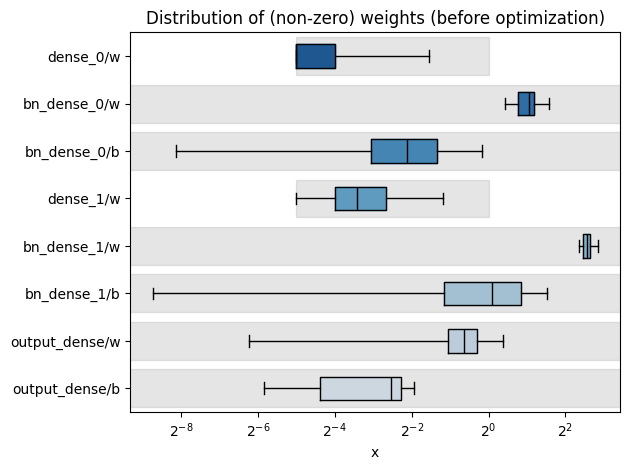

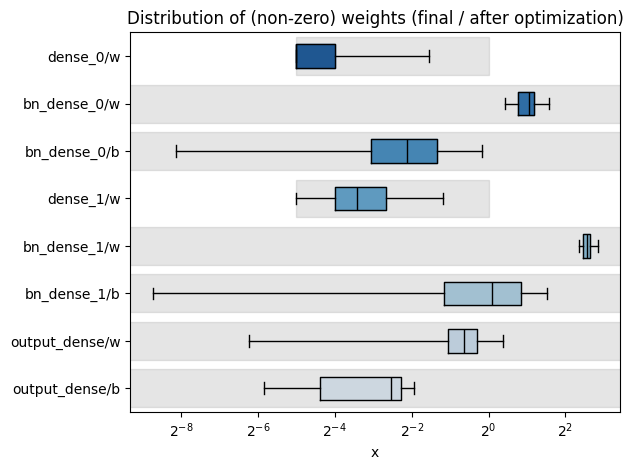

In [21]:
numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

In [22]:
y_predict = model.predict(x_test)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 0s 337us/step


In [23]:
y_predict_q = qmodel.predict(x_test)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 0s 531us/step


In [24]:
import re
import os
def update_tcl_config(project_dir: str, new_max_size: int, default_part: str = 'xc7z020clg400-1'):
    tcl_path = os.path.join(project_dir, 'project.tcl')
    if not os.path.exists(tcl_path):
        print(f"File not found: {tcl_path}")
        return

    with open(tcl_path, 'r') as file:
        lines = file.readlines()

    max_updated, part_updated = False, False
    for i, line in enumerate(lines):
        if re.match(r'^set\s+maximum_size\s+\d+', line):
            lines[i] = f"set maximum_size {new_max_size}\n"
            max_updated = True
        elif re.match(r'^set\s+part\s+\".*\"$', line):
            lines[i] = f'set part "{default_part}"\n'
            part_updated = True

    if not max_updated:
        lines.append(f"set maximum_size {new_max_size}\n")

    with open(tcl_path, 'w') as file:
        file.writelines(lines)

    print(f" maximum_size set to {new_max_size}")
    print(f" part set to '{default_part}'" if part_updated else f" part already matches '{default_part}'")

In [ ]:
synth = True  # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model_q.build(csim=False, synth=True, export=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.2 (64-bit)
  **** SW Build 5238294 on Nov  8 2024
  **** IP Build 5239520 on Sun Nov 10 16:12:51 MST 2024
  **** SharedData Build 5239561 on Fri Nov 08 14:39:27 MST 2024
  **** Start of session at: Tue Jul  1 20:42:40 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /mnt/f/Xilinx/Vitis/2024.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'theodoros' on host 'SagittariusA.localdomain' (Linux_x86_64 version 6.6.87.2-microsoft-standard-WSL2) on Tue Jul 01 20:42:42 EEST 2025
INFO: [HLS 200-10] On os Ubuntu 24.04.2 LTS
INFO: [HLS 200-10] In directory '/home/theodoros/Projects/AI_ON_FPGA/Projects/Quantized'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/home/theodoros/Projects/AI_ON_FPGA/Projects/Quantized/mypr

In [ ]:
synth = True  # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model.build(csim=False, synth=True, export=True)